# SNAKE GAME AI with NEAT

In [ ]:
import random
import neat
import time
import copy
import pickle
import os

## Snake Game

In [ ]:
mapSize = 20
start_len = 4          # snake start length (20x20:4, 10x10:3)
sLen = start_len       # snake length
startX, startY = 8, 10 # 20x20:8,10 / 10x10:4,5
headX, headY = startX, startY
snake_dir = 1

BLANK, SNAKE, FOOD, WALL = 0, 1, 2, 3

mapM = [[BLANK]*(mapSize+2) for i in range(mapSize+2)]
sInfo = []
score = 0
move = 0     # increase until eat food, become 0 after eat food.

def new_food(rdm=True, ipt=[]):   # set new food
    global mapSize, mapM
    if rdm:
        foodX, foodY = 0, 0
        while mapM[foodX][foodY] != BLANK:
            foodX = random.randrange(1,mapSize)
            foodY = random.randrange(1,mapSize)
        mapM[foodX][foodY] = FOOD
    else:
        foodX, foodY = ipt[0], ipt[1]
        mapM[foodX][foodY] = FOOD
    return foodX, foodY

def new_map(food_rdm=True, food_input=[]):    # start new game: make new map
    global mapM, mapSize, WALL, SNAKE, sLen, headX, headY, sInfo, score, move, snake_dir, start_len, startX, startY
    headX, headY = startX, startY
    sLen = start_len
    score = 0
    move = 0
    snake_dir = 1
    
    for i in range(mapSize+2):   # initialize
        for j in range(mapSize+2):
            mapM[i][j] = 0
    
    for i in range(mapSize+2):   # make wall
        mapM[0][i] = WALL
        mapM[mapSize+1][i] = WALL
        mapM[i][0] = WALL
        mapM[i][mapSize+1] = WALL

    sInfo = []
    for i in range(sLen):        # make snake
        mapM[headX-i][headY] = SNAKE
        sInfo.append(((headX-i), headY))

    fX, fY = new_food(food_rdm, food_input)              # make food
    return fX, fY

def move_snake(dr, food_rdm=True, food_input=[]):       # make snake one step
    global mapSize, WALL, FOOD, SNAKE, BLANK, mapM, headX, headY, sLen, score, snake_dir, move, sInfo
    if mapSize == 20:
        move_max = max([100, score*15-200])
        move_max = min([move_max, mapSize*mapSize])
    elif mapSize == 10:
        move_max = 200
    
    hit = False
    fX, fY = -1, -1
    
    dx = [0, 1, 0, -1]
    dy = [-1, 0, 1, 0]
    nextX = headX + dx[dr]
    nextY = headY + dy[dr]
    nextM = mapM[nextX][nextY]
    if nextM == WALL or nextM == SNAKE:
        hit = True
    else:
        snake_dir = dr
        sInfo.insert(0, (nextX, nextY))
        mapM[nextX][nextY] = SNAKE
        if nextM == BLANK:
            tail = sInfo.pop()
            mapM[tail[0]][tail[1]] = BLANK
            move = move + 1
            if move > move_max:
                hit = True
        else:  # FOOD
            sLen = sLen + 1
            fX, fY = new_food(food_rdm, food_input)
            score = score + 1
            move = 0
        headX = nextX
        headY = nextY
    return hit, [fX, fY]

In [ ]:
def detect(dr, obj, mode):
    # obj: 0(North) ~ 7(Northwest) Clockwise
    # mode: distance = 0, binary = 1
    global headX, headY, mapM, WALL    
    dx = [0, 1, 1, 1, 0, -1, -1, -1]
    dy = [-1, -1, 0, 1, 1, 1, 0, -1]
    cnt = 1
    val = mapM[headX+cnt*dx[dr]][headY+cnt*dy[dr]]
    while val != WALL:
        if val == obj:
            break
        else:
            cnt = cnt + 1
            val = mapM[headX+cnt*dx[dr]][headY+cnt*dy[dr]]
            if val == WALL and obj != WALL:   # no food or body
                return 0
    if mode % 2 == 0:
        return 1.0/cnt
    elif mode == 1:
        return 1

# input: Net -> output: score
def snake_play_game(net, mode = 0, prev = True):
    # mode: distance = 0, binary = 1, body as wall
    # prev: add previous out
    global score, headX, headY, SNAKE, FOOD, WALL, mapM, snake_dir
    
    dir_list = []
    food_list = []
    
    fX, fY = new_map()
    food_list.append([fX, fY])

    hit = False
    detect_order = [[0,1,2,3,4,5,6,7],
                    [2,3,4,5,6,7,0,1],
                    [4,5,6,7,0,1,2,3],
                    [6,7,0,1,2,3,4,5]]
    
    prev_out = 0
    while not hit:
        prev_dir = [0]*3
        prev_dir[prev_out] = 1
        detect_info = []
        for i in detect_order[snake_dir]:
            detect_info.append(detect(i, FOOD, mode))
            if mode != 2:
                detect_info.append(detect(i, WALL, mode))
                detect_info.append(detect(i, SNAKE, mode))
            else:
                detect_info.append(max(detect(i, WALL, mode), detect(i, SNAKE, mode)))
        if prev:
            detect_info = detect_info + prev_dir
        out_data = net.activate(detect_info)     # [turn left, go straight, turn right]
        prev_out = out_data.index(max(out_data))
        next_dir = (snake_dir + prev_out + 3) % 4
        dir_list.append(next_dir)
        hit, [fX, fY] = move_snake(next_dir)
        if fX > 0 and fY > 0:
            food_list.append([fX, fY])
    
    return score, dir_list, food_list

In [ ]:
fitness_max = []
best_dir_list = []
best_food_list = []
best_genome_list = []
best_score_list = []
best_score_acc_list = []
avg_score_list = []
generation = 0
n_snake = 200
input_mode = 0
training_num = 5

def eval_genomes(genomes, config):
    global fitness_max, best_dir_list, best_food_list, best_genome_list, best_score_list, generation
    generation = generation + 1
    start_time = time.time()
    max_f = 1.0
    best_dir, best_food, best_score = [], [], 0
    best_genome = None
    score_sum = 0
    
    for genome_id, genome in genomes:
        genome.fitness = 1.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        score, dir_list, food_list = snake_play_game(net, mode=input_mode)
        score_sum = score_sum + score
        step = len(dir_list)
        genome.fitness = step + ((2**score) + (score**2.1)*500) - (((.25 * step)**1.3) * (score**1.2))
        if max_f < genome.fitness:
            best_dir = dir_list
            best_food = food_list
            best_genome = genome
            best_score = score
            max_f = genome.fitness_max
            
    best_dir_list.append(best_dir)
    best_food_list.append(best_food)
    best_genome_list.append(copy.deepcopy(best_genome))
    best_score_list.append(best_score)
    fitness_max.append(max_f)
    best_score_acc = max(best_score_list)
    best_score_acc_list.append(best_score_acc)
    avg_score_list.append(float(score_sum)/float(n_snake))
    
    # if best score change, save lists for plot and animation / temporary save
    if best_score == best_score_acc or generation % 5 == 0:
        dir_name = "./neat-checkpoints-"+str(training_num)
        endstr = "_best"
        if generation % 5 == 0:
            endstr = "_temp"
        with open(dir_name+"/best_dir_list"+endstr+".txt", "wb") as fp:
            pickle.dump(best_dir_list, fp)
        with open(dir_name+"/best_food_list"+endstr+".txt", "wb") as fp:
            pickle.dump(best_food_list, fp)
        with open(dir_name+"/best_score_list"+endstr+".txt", "wb") as fp:
            pickle.dump(best_score_list, fp)
        with open(dir_name+"/best_score_acc_list"+endstr+".txt", "wb") as fp:
            pickle.dump(best_score_acc_list, fp)
    
    eval_time = time.time() - start_time
    print("Generation %4d" % (generation), end=": ")
    print("%6.3f" % (float(score_sum)/float(n_snake)), end = " / ") 
    print("%3d" % best_score, end=" / ")
    print("%3d" % best_score_acc, end=" / ")
    print("%.4e / %6.3fs" % (max_f, eval_time))

## Training

In [ ]:
generation = 0  # start point
max_gen = 1000    # end point
train_start = time.time()
config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         'config')
pop = neat.population.Population(config)
if generation > 0:
    dir_name = './neat-checkpoints-'+str(training_num)
    pop = neat.Checkpointer.restore_checkpoint(dir_name+'/neat-checkpoint-'+str(generation))
    with open(dir_name+"/best_dir_list_temp.txt", "rb") as fp:
        best_dir_list = pickle.load(fp)
    with open(dir_name+"/best_food_list_temp.txt", "rb") as fp:
        best_food_list = pickle.load(fp)
    with open(dir_name+"/best_score_list_temp.txt", "rb") as fp:
        best_score_list = pickle.load(fp)
    with open(dir_name+"/best_score_acc_list_temp.txt", "rb") as fp:
        best_score_acc_list = pickle.load(fp)
    best_dir_list.pop(); best_food_list.pop(); best_score_list.pop(); best_score_acc_list.pop()
    
if not os.path.isdir('./neat-checkpoints-'+str(training_num)):
    os.mkdir('./neat-checkpoints-'+str(training_num))
pf = './neat-checkpoints-'+str(training_num)+'/neat-checkpoint-'
pop.add_reporter(neat.Checkpointer(5, filename_prefix=pf))
winner = pop.run(eval_genomes, max_gen-generation)

time_total = time.time() - train_start
min_total = int(time_total) // 60
sec_total = time_total - min_total*60.0
hour_total = min_total // 60
min_total = min_total - 60*hour_total
print("Training Finished: %dh %dm %.3fs" % (hour_total, min_total, sec_total))

## Plot

1016 1097 1017 1219 1021 1292 1277 1188 1332 1153 1088 1006 1461 1214 1118 1084 1037 990 1128 1096 
271 269 269 266 265 261 260 258 257 257 257 257 256 256 256 256 256 256 255 255 

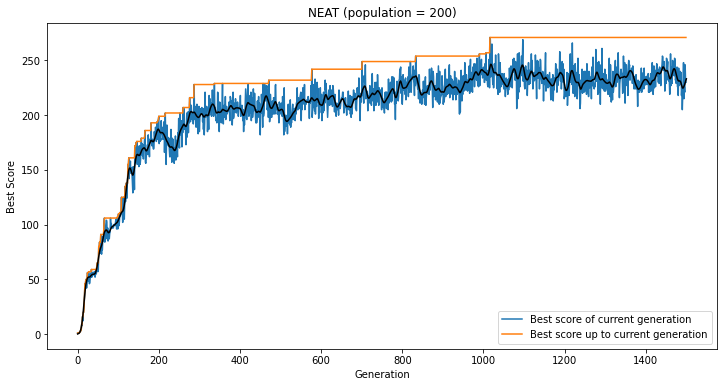

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from csaps import csaps

# Plot Best Score vs. Generation
xlen = len(best_score_list)
x = np.linspace(0., float(xlen), xlen)
xs = np.linspace(0., float(xlen), xlen*5)
y = np.array(best_score_list)
ys = csaps(x, y, xs, smooth=0.02)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(range(xlen), best_score_list, range(xlen), best_score_acc_list, xs, ys, 'k')
plt.xlabel('Generation')
plt.ylabel('Best Score')
plt.legend(["Best score of current generation", "Best score up to current generation"], loc='lower right')
plt.title("NEAT (population = 200)")

ntop = 20
idx = sorted(range(len(best_score_list)),key= lambda i: best_score_list[i])[-ntop:]
idx.reverse()
for i in range(ntop):
    print(idx[i], end=" ")
print()
for i in range(ntop):
    print(best_score_list[idx[i]], end=" ")

## Animation

Animation HTML file is so big to show in jupyter notebook (status_breakpoint error occured), so just download the HTML file

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

# Print iterations progress
def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    if iteration == total: 
        print()

# make animation with dir_list and food_list
food_cnt = 1
def make_ani(dir_list, food_list, itv = 20):
    from matplotlib.animation import FuncAnimation
    import matplotlib
    global food_cnt
    matplotlib.rcParams['animation.embed_limit'] = 2**128

    new_map(food_rdm=False, food_input=food_list[0])
    food_cnt = 1

    f, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-0.5, mapSize+1.5), ax.set_ylim(-0.5, mapSize+1.5)
    plt.gca().invert_yaxis()
    im = plt.imshow(np.array(mapM).T)

    def init():
        im.set_data(np.array(mapM).T)
        printProgressBar(0, len(dir_list), prefix = 'Animation:', suffix = 'Complete', length = 50)
        return [im]

    def update(frame):
        global mapM, food_cnt
        if frame > 0:
            if food_cnt >= len(food_list):
                food_cnt = food_cnt - 1
            hit, fXY = move_snake(dir_list[frame-1], food_rdm=False, food_input=food_list[food_cnt])
            if fXY[0] > 0:
                food_cnt = food_cnt + 1
        im.set_data(np.array(mapM).T)
        printProgressBar(frame, len(dir_list), prefix = 'Animation:', suffix = 'Complete', length = 50)
        return [im]

    ani = FuncAnimation(fig=f, func=update, frames=range(len(dir_list)+1), init_func=init, blit=True, interval=itv)
    plt.close(f)
    
    return ani.to_jshtml()
    
gen = idx[0]
print("Generation "+str(gen+1)+": "+str(len(best_dir_list[gen])+1)+" frames")
ani_html = make_ani(best_dir_list[gen], best_food_list[gen], 5)

Html_file = open("animation_"+str(gen+1)+"_"+str(best_score_list[gen])+".html","w")
Html_file.write(ani_html)

Generation 1017: 21630 frames
Animation: |██████████████████████████████████████████████████| 100.0% Complete


235553537

## Load lists

In [ ]:
import pickle

endstr = "_neat_best"
with open("./snake_save_neat/best_dir_list"+endstr+".txt", "rb") as fp:
    best_dir_list = pickle.load(fp)
with open("./snake_save_neat/best_food_list"+endstr+".txt", "rb") as fp:
    best_food_list = pickle.load(fp)
with open("./snake_save_neat/best_score_list"+endstr+".txt", "rb") as fp:
    best_score_list = pickle.load(fp)
with open("./snake_save_neat/best_score_acc_list"+endstr+".txt", "rb") as fp:
    best_score_acc_list = pickle.load(fp)

## Test best genome

In [ ]:
import neat

n_test = 500
net = neat.nn.FeedForwardNetwork.create(best_genome_list[gen], config)
test_score_list = []
test_dir_list = []
test_food_list = []

for i in range(n_test):
    score, dir_list, food_list = snake_play_game(net, 0)
    test_score_list.append(score)
    test_dir_list.append(dir_list)
    test_food_list.append(food_list)
    
id = sorted(range(len(test_score_list)),key= lambda i: test_score_list[i])[-20:]
id = get_top_idx
id.reverse()
print("Index: ", end="")
for i in range(20):
    print(id[i], end=" ")
print("\nScore: ", end="")
for i in range(20):
    print(test_score_list[id[i]], end=" ")
print("\nAvg. Score: %.3f" % (float(sum(test_score_list))/float(n_test)))

print(str(id[0])+": "+str(len(test_dir_list[id[0]])+1)+" frames")
ani_html = make_ani(test_dir_list[id[0]], test_food_list[id[0]], 5)
Html_file = open("animation_test_"+str(test_score_list[id[0]])+".html","w")
Html_file.write(ani_html)

Index: 244 213 459 442 440 242 164 168 488 160 318 229 277 413 354 360 321 308 141 201 
Score: 244 239 238 238 231 231 231 230 225 223 222 222 220 219 218 217 217 217 217 216 
Avg. Score: 166.212
244: 20288 frames
Animation: |██████████████████████████████████████████████████| 100.0% Complete


220570865

## VISUALIZE  
- graphviz not working now  
- make text file of genome and visualize in different environment

In [ ]:
import pickle

model = best_genome_list[gen]
with open("neat_best_genome_"+str(gen+1)+"_"+str(best_score_list[gen])+".txt", "wb") as fp:
    pickle.dump(model, fp)
print(model)

Key: 2712
Fitness: 5.391989333430128e+67
Nodes:
	0 DefaultNodeGene(key=0, bias=0.02402952363157723, response=1.0, activation=sigmoid, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.5073328466999251, response=1.0, activation=sigmoid, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-1.810983203657913, response=1.0, activation=sigmoid, aggregation=sum)
	5463 DefaultNodeGene(key=5463, bias=-0.2316499649428703, response=1.0, activation=sigmoid, aggregation=sum)
	5947 DefaultNodeGene(key=5947, bias=-0.37763631498526556, response=1.0, activation=sigmoid, aggregation=sum)
	9559 DefaultNodeGene(key=9559, bias=-0.36538236125388684, response=1.0, activation=sigmoid, aggregation=sum)
	10845 DefaultNodeGene(key=10845, bias=2.210465290471783, response=1.0, activation=sigmoid, aggregation=sum)
	11116 DefaultNodeGene(key=11116, bias=3.632181058561941, response=1.0, activation=sigmoid, aggregation=sum)
	11193 DefaultNodeGene(key=11193, bias=-0.19447525733374554, response=1.0, activation=sigmoid, agg